In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.92 ):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [3]:
import os

os.environ['KAGGLE_USERNAME'] = "aldionsumampouw" # username from the json file
os.environ['KAGGLE_KEY'] = "5c621105978afeebbfe85ce3fa278105" # key from the json file

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:02<00:00, 183MB/s]
100% 346M/346M [00:02<00:00, 159MB/s]


In [5]:
!unzip intel-image-classification.zip > /dev/null

In [6]:
!rm -rf seg_test/ seg_pred/

In [7]:
os.listdir('seg_train/seg_train/')

['sea', 'glacier', 'mountain', 'buildings', 'forest', 'street']

In [8]:
print('total mountain train images :', len(os.listdir('seg_train/seg_train/mountain')))
print('total sea train images :', len(os.listdir('seg_train/seg_train/sea')))
print('total buildings train images :', len(os.listdir('seg_train/seg_train/buildings')))
print('total forest train images :', len(os.listdir('seg_train/seg_train/forest')))
print('total glacier train images :', len(os.listdir('seg_train/seg_train/glacier')))
print('total street train images :', len(os.listdir('seg_train/seg_train/street')))

total mountain train images : 2512
total sea train images : 2274
total buildings train images : 2191
total forest train images : 2271
total glacier train images : 2404
total street train images : 2382


In [9]:
train_dir = os.path.join('seg_train/seg_train')
train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.1,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.2) # set validation split

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])

In [13]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,batch_size = 64,
                    callbacks=[callbacks],verbose=2)

Epoch 1/50
1404/1404 - 109s - loss: 1.0589 - accuracy: 0.5776 - val_loss: 0.8579 - val_accuracy: 0.6605
Epoch 2/50
1404/1404 - 78s - loss: 0.8146 - accuracy: 0.6861 - val_loss: 0.7597 - val_accuracy: 0.7200
Epoch 3/50
1404/1404 - 77s - loss: 0.6888 - accuracy: 0.7394 - val_loss: 0.7397 - val_accuracy: 0.7372
Epoch 4/50
1404/1404 - 77s - loss: 0.6007 - accuracy: 0.7807 - val_loss: 0.7267 - val_accuracy: 0.7275
Epoch 5/50
1404/1404 - 78s - loss: 0.5550 - accuracy: 0.7989 - val_loss: 0.6138 - val_accuracy: 0.7817
Epoch 6/50
1404/1404 - 75s - loss: 0.5120 - accuracy: 0.8100 - val_loss: 0.5942 - val_accuracy: 0.7892
Epoch 7/50
1404/1404 - 75s - loss: 0.4580 - accuracy: 0.8320 - val_loss: 0.6080 - val_accuracy: 0.7885
Epoch 8/50
1404/1404 - 75s - loss: 0.4025 - accuracy: 0.8546 - val_loss: 0.5814 - val_accuracy: 0.7946
Epoch 9/50
1404/1404 - 76s - loss: 0.3854 - accuracy: 0.8620 - val_loss: 0.5781 - val_accuracy: 0.8024
Epoch 10/50
1404/1404 - 75s - loss: 0.3438 - accuracy: 0.8768 - val_loss

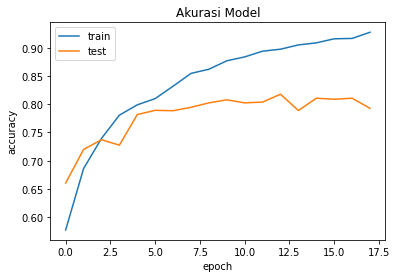

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

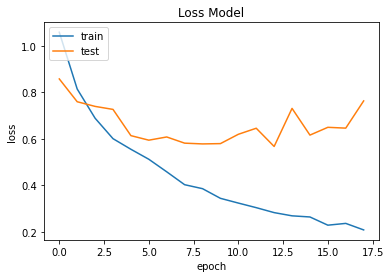

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcqlee7c9/assets


In [18]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)